## Leads

Projeto prático do AceleraDev Data Science, oferecido pela Codenation em junho de 2020. Este notebook foi desenvolvido por Vinicius Aguiar e esta disponível em [github.com/vncsna/leads](https://github.com/vncsna/leads). Durante o desenvolvimento analisei e incorporei o conteúdo compartilhado na comunidade, em específico de [tkleyton](https://github.com/tkleyton) e [diasctiago](https://github.com/diasctiago).

### Configuração

In [1]:
from pathlib import Path
from IPython.display import clear_output

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (
    Normalizer,
    MinMaxScaler,
    OneHotEncoder,
    LabelBinarizer)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')
datadir = Path('/content/drive/My Drive/codenation/market-leads/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Análise Exploratória

#### Leitura e Sanity Check

Faço a leitura dos arquivos, identificando cada amostra. Logo deleto a coluna redundante com número das linhas.

Daí checo o formato dos conjuntos de dados. E analiso se os valores dos portfolios 1, 2 e 3 estão contidos no banco de dados de mercado.

In [3]:
market = pd.read_csv(datadir / 'estaticos_market.csv', index_col='id')
port1 = pd.read_csv(datadir / 'estaticos_portfolio1.csv', index_col='id')
port2 = pd.read_csv(datadir / 'estaticos_portfolio2.csv', index_col='id')
port3 = pd.read_csv(datadir / 'estaticos_portfolio3.csv', index_col='id')

market = market.drop('Unnamed: 0', axis=1)
port1 = port1.drop('Unnamed: 0', axis=1)
port2 = port2.drop('Unnamed: 0', axis=1)
port3 = port3.drop('Unnamed: 0', axis=1)

print(f'market tem formato {market.shape}')
print(f'port1 tem formato {port1.shape}')
print(f'port2 tem formato {port2.shape}')
print(f'port3 tem formato {port3.shape}')
print()

try:
  if (market.columns == port1.columns).all():
    print('market e port1 tem as mesmas colunas')
  mesmas_linhas = True
  for i in port1.index:
    market_row = market.loc[i, :].dropna()
    port1_row = port1.loc[i, :].dropna()
    if not (market_row == port1_row).all():
      mesmas_linhas = False
  if mesmas_linhas:
    print('market e port1 tem as mesmas linhas')
  port1 = port1.drop(port1.columns, axis=1)
  print('deleto então os dados redundantes')
except:
  print('port1 não está contido em market')

try:
  for i in port2.index:
    market.loc[i, :]
  for i in port3.index:
    market.loc[i, :]
  print('ids de port2 e port3 existem em market')
except:
  print('ids de port2 ou port3 não existem em market')

market tem formato (462298, 180)
port1 tem formato (555, 180)
port2 tem formato (566, 0)
port3 tem formato (265, 0)

market e port1 tem as mesmas colunas
market e port1 tem as mesmas linhas
deleto então os dados redundantes
ids de port2 e port3 existem em market


#### Sumarização e Correlação

Então gero funções para visualizar uma descrição estatística e uma matriz de correlações. Elas serão utilizadas para a análise dos dados durante o tratamento.

In [ ]:
def summary(verbose=True):
  if verbose:
    print('inicializo um dataframe de informações')
  market_info = pd.DataFrame(None, columns=market.columns)
  if verbose:
    print('  adiciono a quantidade de dados faltantes')
  na_row = (market.isnull().sum(axis=0) / market.shape[0])
  na_row = na_row.to_numpy().reshape(1, -1).round(4)
  na_row =  pd.DataFrame(na_row, index=['na'], columns=market.columns)
  market_info = market_info.append(na_row)
  if verbose:
    print('  adiciono os tipos de dados')
  dtypes_row = np.array([str(t) for t in market.dtypes]).reshape(1, -1)
  dtypes_row = pd.DataFrame(dtypes_row, index=['dtypes'], columns=market.columns)
  market_info = market_info.append(dtypes_row)
  if verbose:
    print('  adiciono a quantidade de categorias')
  nobjects_row = np.zeros((1, market.shape[1]))
  for i in range(market.shape[1]):
    col = market.columns[i]
    if str(market[col].dtype) == 'object':
      nobjects_row[0, i] = market[col].unique().size
    else:
      nobjects_row[0, i] = 0
  nobjects_row = pd.DataFrame(nobjects_row, index=['nobjects'], columns=market.columns)
  market_info = market_info.append(nobjects_row)
  if verbose:
    print('  adiciono as estatísticas de primeira ordem')
  market_info = market_info.append(market.describe(include='all'))
  return market_info

def correlation():
  corr = market.corr()
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = True
  fig, ax = plt.subplots(figsize=(14, 14))
  cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)
  ax = sns.heatmap(corr, cmap=cmap, annot=True, fmt='.2f', 
                    linewidths=1, square=True, mask=mask);

### Tratamento

#### Seleção das variáveis

Seleciono para uso apenas as colunas com menos de 10% de dados faltantes. Das restantes descarto as sem significado, inconsistentes, redundantes ou com alta cardinalidade.

In [5]:
market = market.loc[:, summary(False).loc['na', :] <= .1]

# em relação as variáveis redundantes. Falta
# escolher entre deletar de_natureza_juridica ou natureza_juridica_macro?
# escolher entre deletar sg_uf ou sg_uf_matriz?
# escolher entre deletar de_ramo, setor, nm_divisao ou nm_segmento?
# escolher entre deletar idade_empresa_anos ou idade_emp_cat?
# escolher entre
#   de_faixa_faturamento_estimado, de_faixa_faturamento_estimado_grupo,
#   vl_faturamento_estimado_aux ou vl_faturamento_estimado_grupo_aux?
# escolher entre de_saude_rescencia ou nu_meses_rescencia?
# deletar dt_situacao pela cardinalidade e por não ter sentido
print('deleto as variáveis redundantes')
for col in ['de_natureza_juridica', 
            'natureza_juridica_macro', # trade-off entre portfolio 2 e 3
            #'sg_uf',
            'sg_uf_matriz',
            'de_ramo',
            #'setor',
            'nm_divisao',
            'nm_segmento',
            #'idade_empresa_anos',
            'idade_emp_cat',
            'de_faixa_faturamento_estimado',
            'de_faixa_faturamento_estimado_grupo',
            #'vl_faturamento_estimado_aux',
            #'vl_faturamento_estimado_grupo_aux',
            'de_saude_rescencia',
            'nu_meses_rescencia'
            ]:
  print(f'  {col}')
  market = market.drop([col], axis=1)

print('deleto a variável com alta cardinalidade ou sem sentido')
for col in ['dt_situacao',
            'vl_total_veiculos_pesados_grupo',
            'vl_total_veiculos_leves_grupo'
            ]:
  market = market.drop([col], axis=1)

# preciso analisar quais fazem sentido permanecerem 
print('deleto as variáveis booleanas')
for col in [#'fl_matriz',
            'fl_me', 
            'fl_sa', 
            'fl_epp',
            'fl_mei',
            'fl_ltda',
            'fl_st_especial',
            'fl_email',
            'fl_telefone',
            #'fl_rm',
            'fl_spa',
            #'fl_antt',
            #'fl_veiculo',
            'fl_simples_irregular',
            'fl_passivel_iss'
            ]:
  print(f'  {col}')
  market = market.drop([col], axis=1)

deleto as variáveis redundantes
  de_natureza_juridica
  natureza_juridica_macro
  sg_uf_matriz
  de_ramo
  nm_divisao
  nm_segmento
  idade_emp_cat
  de_faixa_faturamento_estimado
  de_faixa_faturamento_estimado_grupo
  de_saude_rescencia
  nu_meses_rescencia
deleto a variável com alta cardinalidade ou sem sentido
deleto as variáveis booleanas
  fl_me
  fl_sa
  fl_epp
  fl_mei
  fl_ltda
  fl_st_especial
  fl_email
  fl_telefone
  fl_spa
  fl_simples_irregular
  fl_passivel_iss


#### Tratamento dos valores nulos e duplicados

Seleciono para uso apenas as colunas com menos de 10% de dados faltantes. Os valores nulos das colunas restantes são preenchidos pela moda em caso de categoria ou pela média em caso numérico.

Dai procuro por dados duplicados e os elimino, com exceção daqueles que estão contidos no portfolio 1. Essa é uma decisão que precisaria ser tomada com alguém que tenha melhor conhecimento dos dados, uma vez que é possível que existam empresas com dados semelhantes.

In [6]:
print('substituo as variáveis nulas')
market['setor'].fillna('OUTROS', inplace=True)
market['vl_faturamento_estimado_aux'].fillna(0, inplace=True)
na_index = market['vl_faturamento_estimado_grupo_aux'].isna()
na_values = 867689 * (market.loc[na_index, 'qt_filiais'] + 1)
market.loc[na_index, 'vl_faturamento_estimado_grupo_aux'] = na_values

for col in market.select_dtypes(['float']):
  market[col] = market[col].fillna(market[col].mean())
for col in market.select_dtypes(['bool', 'object']):
  market[col] = market[col].fillna(market[col].mode()[0])

duplicated = market.duplicated(keep=False)
n_duplicated = duplicated.sum()
n_duplicated_in_port1 = 0
port1_duplicated_index = []
for i, j in zip(duplicated.index, duplicated):
  if j and i in port1.index:
    n_duplicated_in_port1 += 1
    port1_duplicated_index.append(i)
if n_duplicated > 0:
  market = market.loc[port1_duplicated_index, :].append(market)
  market = market.drop_duplicates()
  print('market tem', n_duplicated, 'empresas duplicadas')
  print(f'note que {n_duplicated_in_port1} estão contidas no portfolio 1')
  print('deleto as empresas duplicadas, mantendo as contidas no portfolio 1')
else:
  print('não existem dados duplicados')

substituo as variáveis nulas
market tem 181853 empresas duplicadas
note que 219 estão contidas no portfolio 1
deleto as empresas duplicadas, mantendo as contidas no portfolio 1


#### Tratamento das variáveis categóricas

Transformo variáveis categoricas em numéricas ordinais ou e gero one hot encodings.

In [7]:
print('transformo categorias em valores numéricos')
print('  transformo a coluna fl_rm em booleana')
market['fl_rm'] = [True if item == 'SIM' else False for item in market['fl_rm']]
print('  transformo a coluna de_nivel_atividade em numerico ordinal')
market['de_nivel_atividade'] = market['de_nivel_atividade'].map({
    'MUITO BAIXA': 0.0, 'BAIXA' : 1.0, 
    'MEDIA': 2.0, 'ALTA': 3.0})
print('  transformo a coluna de_saude_tributaria em numerico ordinal')
market['de_saude_tributaria'] = market['de_saude_tributaria'].map({
    'VERMELHO': 0.0, 'LARANJA' : 1.0, 'AMARELO': 2.0, 
    'CINZA': 3.0, 'AZUL': 4.0, 'VERDE': 5.0})

print('gero one hot encoding para as variavéis categóricas')
lb = LabelBinarizer()
for col in market.select_dtypes('object'):
  index = market.index
  encoded = lb.fit_transform(market[col])
  columns = [f'{col}_{i}' for i in lb.classes_]
  encoded = pd.DataFrame(encoded, index=index, columns=columns)
  market = market.drop([col], axis=1)
  market = market.join(encoded)
  print(f'  {col}')

transformo categorias em valores numéricos
  transformo a coluna fl_rm em booleana
  transformo a coluna de_nivel_atividade em numerico ordinal
  transformo a coluna de_saude_tributaria em numerico ordinal
gero one hot encoding para as variavéis categóricas
  sg_uf
  setor


#### Tratamento das variáveis numéricas

Para variáveis com grande variância aplico uma transformação logaritmica. Também converto as variáveis booleanas em numéricas e deleto algumas.

In [ ]:
for col in ['vl_faturamento_estimado_aux', 
            'vl_faturamento_estimado_grupo_aux', 
            'qt_filiais'
            ]:
  market[col] = np.log2(market[col] + 1)

for col in market.select_dtypes(include=['bool']):
  market[col] = market[col].astype(float)

#### Normalização e criação de prioridades

In [9]:
print('ordeno as colunas')
columns = sorted(market.columns.values)
market = market[columns]

print('normalizo as colunas')
scaler = MinMaxScaler()
for col in market:
  values = market[col].to_numpy().reshape(-1, 1)
  market[col] = scaler.fit_transform(values)

print('proponho prioridades para as variáveis')
for col in ['idade_empresa_anos',
            'qt_filiais',
            'vl_faturamento_estimado_aux',
            'vl_faturamento_estimado_grupo_aux'
            ]:
  market[col] = market[col]

print('atualizo os portfolios com dados tratados')
port1 = port1.join(market, how='inner')
port2 = port2.join(market, how='inner')
port3 = port3.join(market, how='inner')

ordeno as colunas
normalizo as colunas
proponho prioridades para as variáveis
atualizo os portfolios com dados tratados


### Treinamento dos Modelos

#### Algoritmo de Similaridade de Cossenos

In [ ]:
class CosineSimilarityModel:
  def __init__(self, market):
    self.name = 0
    self.portfolio = 0
    self.similarity = 0
    self.market = market
  def train(self, portfolio, name):
    self.name = name
    self.portfolio = portfolio
    self.similarity = cosine_similarity(self.market, self.portfolio)
  def gen_guess(self, n_guess, train):
    shape = (self.market.shape[0], len(train))
    guess = self.similarity[:, train]
    guess = np.argsort(guess, axis=None)[-(n_guess * len(train)):]
    guess = np.unique(np.unravel_index(guess, shape)[0])
    guess = [self.market.index[i] for i in guess]
    return guess
  def get_random_guess(self, n_guess=4):
    train_idx, valid_idx = train_test_split(
        np.arange(self.portfolio.shape[0]), test_size=.3)
    valid = [self.portfolio.index[i] for i in valid_idx]
    guess = self.gen_guess(n_guess, train_idx)
    return valid, guess
  def cross_validate(self, n_guess=4, n_folds=5):
    retrival = np.zeros((n_folds, ))
    precision = np.zeros((n_folds, ))
    sensibility = np.zeros((n_folds, ))
    for k in range(n_folds):
      train_idx, valid_idx = train_test_split(
          np.arange(self.portfolio.shape[0]), test_size=.3)
      guess = self.gen_guess(n_guess, train_idx)
      train_lbl = [self.portfolio.index[i] for i in train_idx]
      valid_lbl = [self.portfolio.index[i] for i in valid_idx]
      guess_in_train = [item for item in guess if item in train_lbl]
      guess_in_valid = [item for item in guess if item in valid_lbl]
      retrival[k] = len(guess_in_train) / len(train_idx)
      precision[k] = len(guess_in_valid) / len(guess)
      sensibility[k] = len(guess_in_valid) / len(valid_idx)
    print(f'\n{100 * retrival.mean():0>6.2f} ± {100 * retrival.std():0>6.2f}',
          f'% de retorno no {self.name} utilizando {len(guess)} sugestões.')
    print(f'{100 * precision.mean():0>6.2f} ± {100 * precision.std():0>6.2f}',
          f'% de precisão no {self.name} utilizando {len(guess)} sugestões.')
    print(f'{100 * sensibility.mean():0>6.2f} ± {100 * sensibility.std():0>6.2f}', 
          f'% de sensibilidade no {self.name} utilizando {len(guess)} sugestões.')

In [11]:
csm1 = CosineSimilarityModel(market)
csm1.train(port1, 'portolio 1')
csm1.cross_validate()

csm2 = CosineSimilarityModel(market)
csm2.train(port2, 'portolio 2')
csm2.cross_validate()

csm3 = CosineSimilarityModel(market)
csm3.train(port3, 'portolio 3')
csm3.cross_validate()


100.00 ± 000.00 % de retorno no portolio 1 utilizando 1538 sugestões.
000.16 ± 000.05 % de precisão no portolio 1 utilizando 1538 sugestões.
001.44 ± 000.48 % de sensibilidade no portolio 1 utilizando 1538 sugestões.

100.00 ± 000.00 % de retorno no portolio 2 utilizando 935 sugestões.
005.99 ± 000.81 % de precisão no portolio 2 utilizando 935 sugestões.
034.24 ± 005.37 % de sensibilidade no portolio 2 utilizando 935 sugestões.

100.00 ± 000.00 % de retorno no portolio 3 utilizando 435 sugestões.
006.98 ± 000.25 % de precisão no portolio 3 utilizando 435 sugestões.
038.25 ± 002.57 % de sensibilidade no portolio 3 utilizando 435 sugestões.


#### Algoritmo de Vizinhos Mais Próximos

In [ ]:
class NearestNeighborsModel:
  def __init__(self, market):
    self.name = 0
    self.portfolio = 0
    self.market = market
    self.model = NearestNeighbors()
    self.model.fit(self.market);
  def gen_guess(self, n_guess, train):
    train = self.portfolio.iloc[train, :]
    guess = self.model.kneighbors(
        train, n_neighbors=n_guess, return_distance=False)
    guess = [market.index[i] for i in np.unique(guess.ravel())]
    return guess
  def get_random_guess(self, n_guess=4):
    train_idx, valid_idx = train_test_split(
          np.arange(self.portfolio.shape[0]), test_size=.3)
    valid = [self.portfolio.index[i] for i in valid_idx]
    guess = self.gen_guess(n_guess, train_idx)
    return valid, guess
  def cross_validate(self, portfolio, name, n_guess=4, n_folds=5):
    self.name = name
    self.portfolio = portfolio
    retrival = np.zeros((n_folds, ))
    precision = np.zeros((n_folds, ))
    sensibility = np.zeros((n_folds, ))
    for k in range(n_folds):
      train_idx, valid_idx = train_test_split(
          np.arange(self.portfolio.shape[0]), test_size=.3)
      guess = self.gen_guess(n_guess, train_idx)
      train_lbl = [self.portfolio.index[i] for i in train_idx]
      valid_lbl = [self.portfolio.index[i] for i in valid_idx]
      guess_in_train = [item for item in guess if item in train_lbl]
      guess_in_valid = [item for item in guess if item in valid_lbl]
      retrival[k] = len(guess_in_train) / len(train_idx)
      precision[k] = len(guess_in_valid) / len(guess)
      sensibility[k] = len(guess_in_valid) / len(valid_idx)
    print(f'\n{100 * retrival.mean():0>6.2f} ± {100 * retrival.std():0>6.2f}',
          f'% de retorno no {self.name} utilizando {len(guess)} sugestões.')
    print(f'{100 * precision.mean():0>6.2f} ± {100 * precision.std():0>6.2f}',
          f'% de precisão no {self.name} utilizando {len(guess)} sugestões.')
    print(f'{100 * sensibility.mean():0>6.2f} ± {100 * sensibility.std():0>6.2f}', 
          f'% de sensibilidade no {self.name} utilizando {len(guess)} sugestões.')

In [13]:
nnm1 = NearestNeighborsModel(market)
nnm1.cross_validate(port1, 'portolio 1')

nnm2 = NearestNeighborsModel(market)
nnm2.cross_validate(port2, 'portolio 2')

nnm3 = NearestNeighborsModel(market)
nnm3.cross_validate(port3, 'portolio 3')


100.00 ± 000.00 % de retorno no portolio 1 utilizando 1545 sugestões.
000.16 ± 000.11 % de precisão no portolio 1 utilizando 1545 sugestões.
001.44 ± 000.97 % de sensibilidade no portolio 1 utilizando 1545 sugestões.

100.00 ± 000.00 % de retorno no portolio 2 utilizando 1154 sugestões.
006.06 ± 000.20 % de precisão no portolio 2 utilizando 1154 sugestões.
041.29 ± 001.31 % de sensibilidade no portolio 2 utilizando 1154 sugestões.

100.00 ± 000.00 % de retorno no portolio 3 utilizando 517 sugestões.
007.17 ± 000.50 % de precisão no portolio 3 utilizando 517 sugestões.
046.25 ± 003.87 % de sensibilidade no portolio 3 utilizando 517 sugestões.


### Avaliação dos Modelos

Dada a proposta de criação de um sistema de recomendação de empresas, desenvolvi o projeto através dos métodos similaridade de cossenos e vizinhos mais próximos. Para os conjuntos de validação fornecidos, dividi os mesmos em treino (70% da base) e teste (30% da base) e utilizei o conjunto de treino para gerar recomendações. Executei esse processo 5 vezes para gerar uma aproximação melhor.

Usei então as métricas de precisão e sensibilidade para avaliação. Então foi possível observar que tanto o modelo baseado na similaridade de cossenos, quanto o baseado nos vizinhos mais próximos tem precisão e sensibilidade semelhantes. De cerca de 0% no portfolio 1 e aproximadamente 40% para os portfolios 2 e 3. Logo ainda não consegui criar vetores representativos o suficiente.

Criei também uma métrica chamada retorno, para analisar se meu conjunto de sugestões de empresa são retornadas pelos métodos utilizados. Esta é uma forma de sanity check. E através dela tive os primeiros indícios da dificuldade de lidar com o portfólio 1.

Abaixo, através da análise de componentes principais para duas dimensões é possível observar o quão próximas estão nossas predições dos casos de teste. Também analiso se as distribuições de certas variáveis são condizentes.

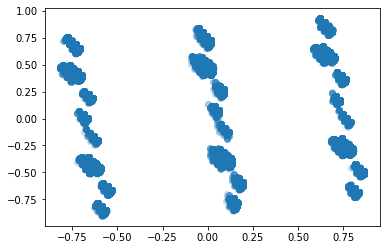

In [14]:
def scatter_comparison(base, guess, ax):
  base_2d = pca.transform(market.loc[base, :])
  guess_2d = pca.transform(market.loc[guess, :])
  ax.scatter(base_2d[:, 0], base_2d[:, 1], alpha=.2);
  ax.scatter(guess_2d[:, 0], guess_2d[:, 1], alpha=.2);

def histogram_comparison(base, guess, feature, ax):
  ax.set_title(feature)
  bins = np.arange(0, 1, .1)
  hist, _ = np.histogram(market.loc[base, feature], bins=bins)
  ax.hist(bins[:-1], bins, label='base', alpha=.6, weights=(hist / hist.sum()))
  hist, _ = np.histogram(market.loc[guess, feature], bins=bins)
  ax.hist(bins[:-1], bins, label='guess', alpha=.6, weights=(hist / hist.sum()))

pca = PCA(n_components=2)
market_2d = pca.fit_transform(market)
plt.scatter(market_2d[:, 0], market_2d[:, 1], alpha=.2);

#### Algoritmo de Similaridade de Cossenos

In [ ]:
base1, guess1 = csm1.get_random_guess()
base2, guess2 = csm2.get_random_guess()
base3, guess3 = csm3.get_random_guess()

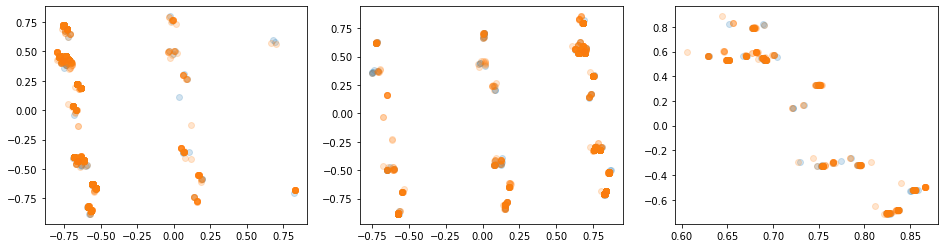

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
scatter_comparison(base1, guess1, ax[0])
scatter_comparison(base2, guess2, ax[1])
scatter_comparison(base3, guess3, ax[2])

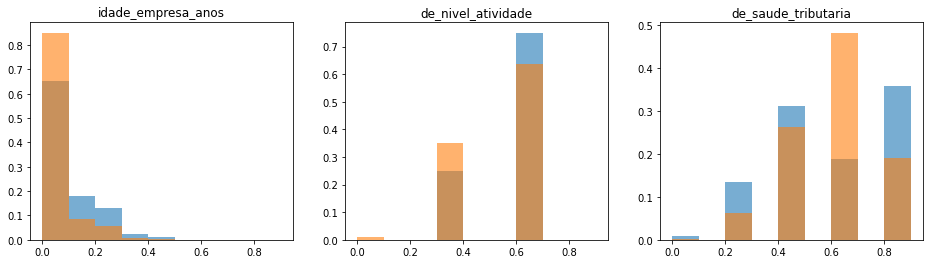

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base1, guess1, 'idade_empresa_anos', ax[0])
histogram_comparison(base1, guess1, 'de_nivel_atividade', ax[1])
histogram_comparison(base1, guess1, 'de_saude_tributaria', ax[2])

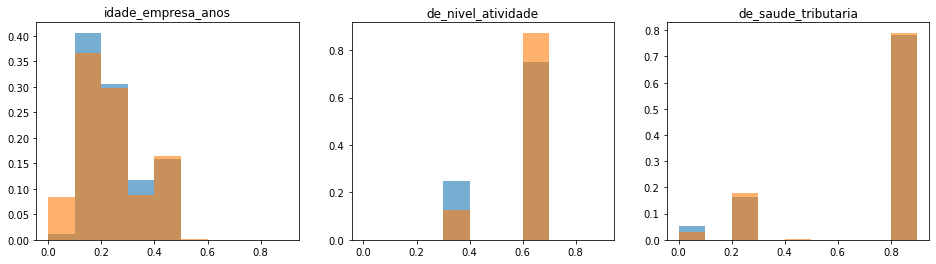

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base2, guess2, 'idade_empresa_anos', ax[0])
histogram_comparison(base2, guess2, 'de_nivel_atividade', ax[1])
histogram_comparison(base2, guess2, 'de_saude_tributaria', ax[2])

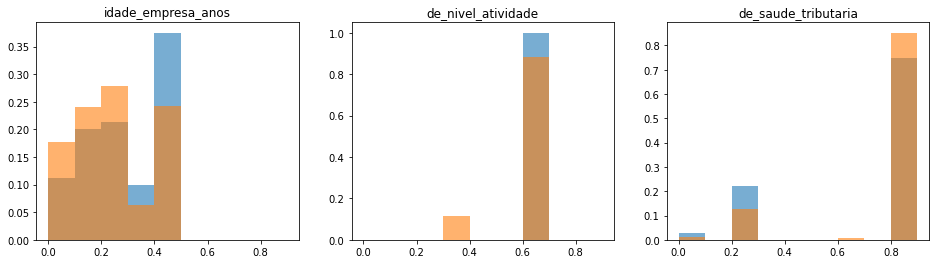

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base3, guess3, 'idade_empresa_anos', ax[0])
histogram_comparison(base3, guess3, 'de_nivel_atividade', ax[1])
histogram_comparison(base3, guess3, 'de_saude_tributaria', ax[2])

#### Algoritmo de Vizinhos Mais Próximos

In [ ]:
base1, guess1 = nnm1.get_random_guess()
base2, guess2 = nnm2.get_random_guess()
base3, guess3 = nnm3.get_random_guess()

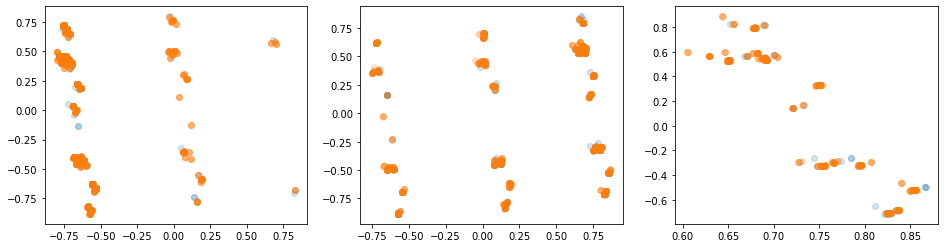

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
scatter_comparison(base1, guess1, ax[0])
scatter_comparison(base2, guess2, ax[1])
scatter_comparison(base3, guess3, ax[2])

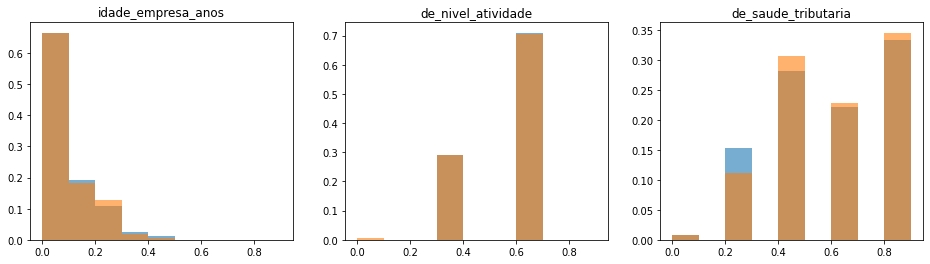

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base1, guess1, 'idade_empresa_anos', ax[0])
histogram_comparison(base1, guess1, 'de_nivel_atividade', ax[1])
histogram_comparison(base1, guess1, 'de_saude_tributaria', ax[2])

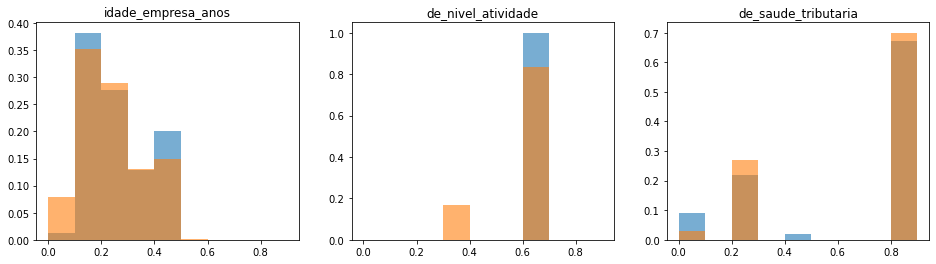

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base2, guess2, 'idade_empresa_anos', ax[0])
histogram_comparison(base2, guess2, 'de_nivel_atividade', ax[1])
histogram_comparison(base2, guess2, 'de_saude_tributaria', ax[2])

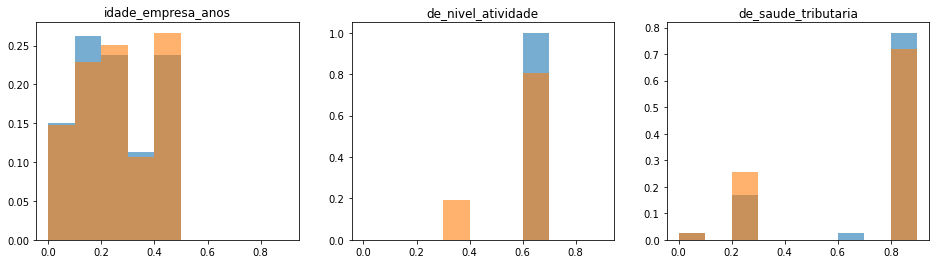

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
histogram_comparison(base3, guess3, 'idade_empresa_anos', ax[0])
histogram_comparison(base3, guess3, 'de_nivel_atividade', ax[1])
histogram_comparison(base3, guess3, 'de_saude_tributaria', ax[2])

#### Conclusão

Em geral essa se mostrou uma boa oportunidade de aprender sobre sistemas de recomendação, sobre quais são seus príncipios e métodos utilizados. E apesar de não ter conseguido um resultado significativo esse projeto evoluiu muito com ajuda de outros membros da comunidade, tanto pela discussão no fórum quanto pelo compartilhamento de código pelo GitHub.

Para projetos futuros pretendo utilizar melhor orientação a objetos, tanto para criação de pipelines, quanto para deploy.